# SVM

Основная идея SVM состоит в том, чтобы провести разделительную линию так, чтобы границы решения были как можно шире, а сама линия находилась максимально далеко от двух ближайших образцов классов.

## Классификация с широким (жестким) зазором

Если SVM пытается построить наиболее возможную широкую полосу границ решения, то такая классификация с SVM называется **классификацией с широким (жестким) зазором**. 

In [1]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC, SVR

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
iris = load_iris()
X = iris['data'][:, (0, 1)]
y = iris['target']

После загрузки датасета выберем первые два класса из 3-х, чтобы показывать примеры на бинарной классификации. Конечно же, на мультиклассовой классификации всё то же самое, просто обучается SVM по стратегии OvO.

In [3]:
X = X[(iris['target'] == 0) | (iris['target'] == 1)]
y = y[(iris['target'] == 0) | (iris['target'] == 1)]

Создадим SVM классификатор, при этом укажем `C` (параметр регуляризации) максимально возможным. Тем самым мы добьемся классификации с широким зазором.

In [4]:
svm = SVC(kernel='linear', C=float(np.inf))
svm.fit(X, y)

SVC(C=inf, kernel='linear')

In [5]:
def plot_svm(svm, X, y, xmin, xmax, ymin, ymax, save=None):
    # Рисуем точки
    plt.figure(figsize=(15, 10))
    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=300, facecolors='yellow')
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], s=50, c='blue', marker='s')
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], s=50, c='red', marker='^')

    # Рисуем границу решений и две линии зазора
    # w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    w = svm.coef_[0]
    b = svm.intercept_[0]
    x0 = np.linspace(xmin, xmax, 200)
    boundary = -w[0]/w[1] * x0 - b/w[1]

    plt.plot(x0, boundary, 'k-', linewidth=2)
    plt.plot(x0, boundary + 1/w[1], 'g--', linewidth=1)
    plt.plot(x0, boundary - 1/w[1], 'g--', linewidth=1)

    # Настройки графика
    plt.xlabel('Длина чашечки', fontsize=24, labelpad=30)
    plt.ylabel('Ширина чашечки', fontsize=24, labelpad=30)
    ax = plt.gca()
    ax.tick_params(labelsize=22)
    plt.axis([xmin, xmax, ymin, ymax])
    if save:
        plt.savefig(save, dpi=200)
    plt.show()

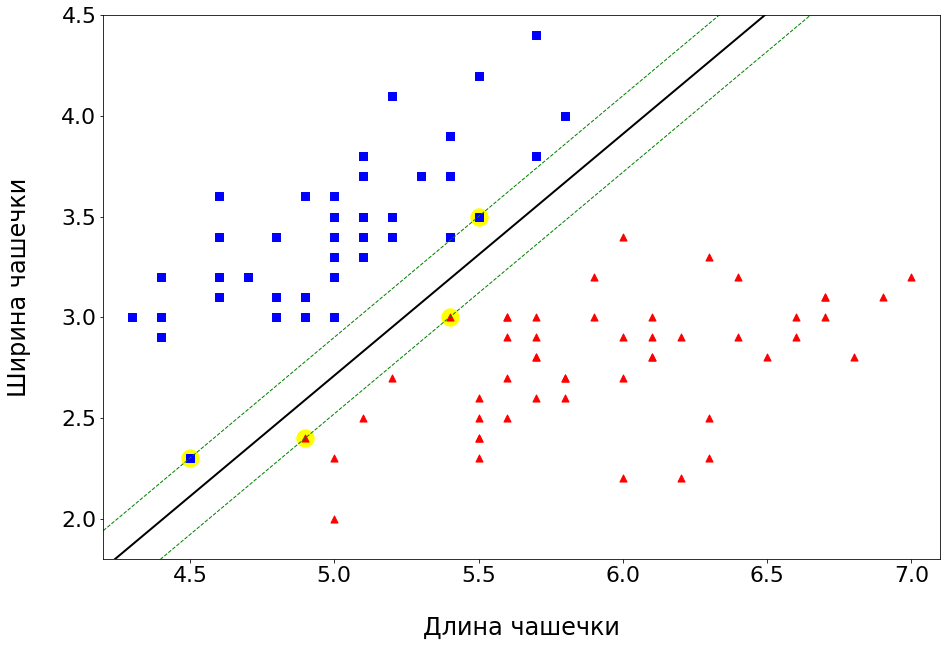

In [6]:
plot_svm(svm, X, y, *[4.2, 7.1, 1.8, 4.5], save='hard_margin.png')

На графике желтым отмечены **опорные вектора**. Полоса решений SVM полностью определяются крайними образцами, лежащими на её границах. Такие образцы как раз и называются опорными векторами. Добавление новых образцов за этой полосой никак не повлияет на неё саму. Однако добавление новых образцов внутрь полосы изменит её, т.к. новые образцы станут новыми опорными векторами. 

## Чувствительность к масштабу

Важно отметить, что SVM **чувствительны** к масштабу признаков!

In [7]:
X = np.array([[1, 50], [5, 20], [3, 80], [5, 60]])
y = np.array([0, 0, 1, 1])

In [8]:
svm = SVC(kernel='linear', C=np.inf)
svm.fit(X, y)

SVC(C=inf, kernel='linear')

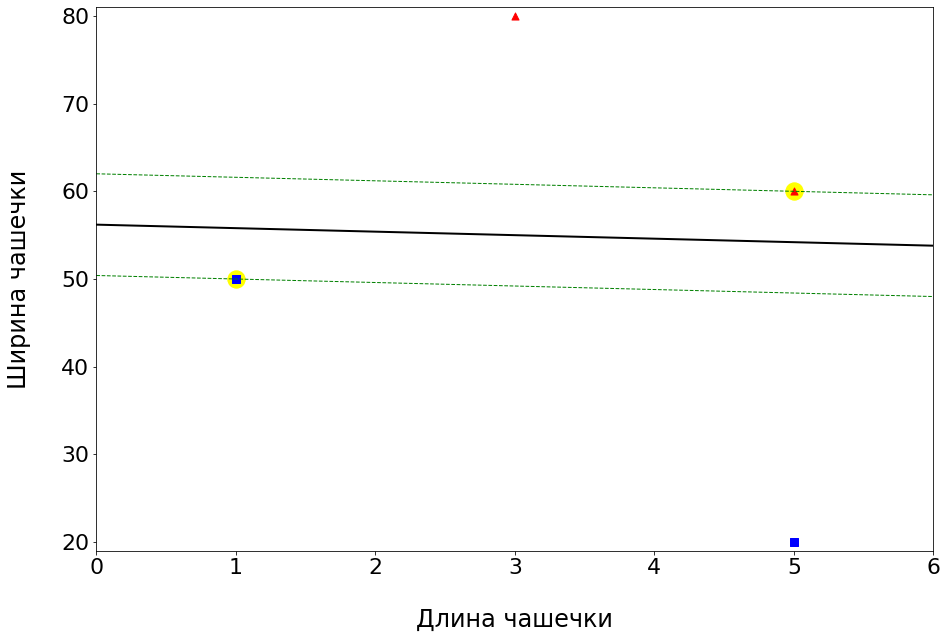

In [9]:
plot_svm(svm, X, y, 
         X[:, 0].min()-1, X[:, 0].max()+1, 
         X[:, 1].min()-1, X[:, 1].max()+1)

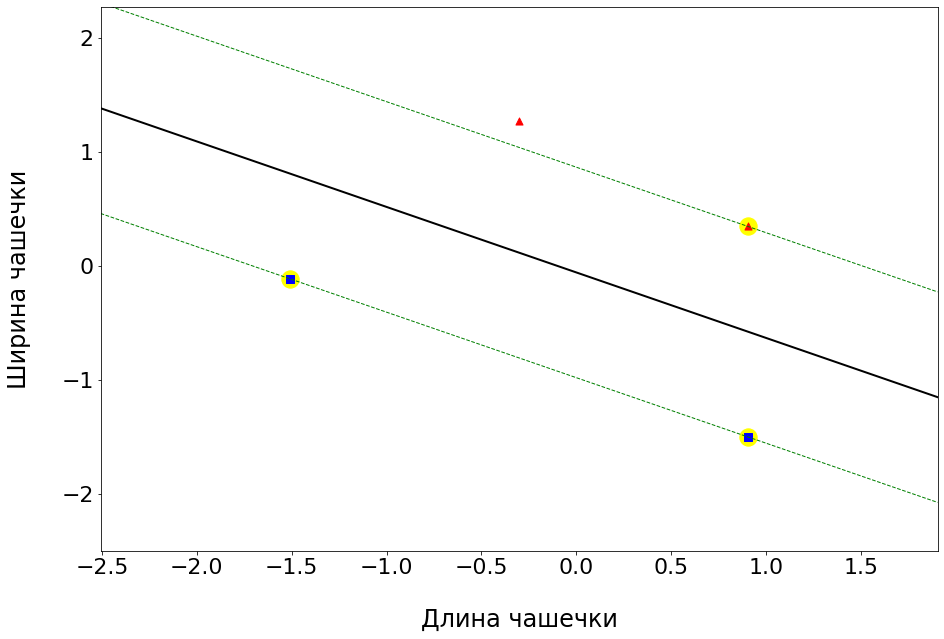

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
svm.fit(X_scaled, y)

plot_svm(svm, X_scaled, y, 
         X_scaled[:, 0].min()-1, X_scaled[:, 0].max()+1, 
         X_scaled[:, 1].min()-1, X_scaled[:, 1].max()+1)

На двух картинках мы можем увидеть значительную разницу в масштабах и то, как SVM под эти масштабы подстраивается. Вполне логично, что во втором случае граница выглядит куда разумнее, чем в первом.

## Чувствительность к выбросам

In [11]:
X = iris['data'][:, (0, 1)]
y = iris['target']

X = X[(iris['target'] == 0) | (iris['target'] == 1)]
y = y[(iris['target'] == 0) | (iris['target'] == 1)]

X_outliers = np.concatenate([X, [[5.5, 3.3]]], axis=0)
y_outliers = np.concatenate([y, [1]], axis=0)

In [12]:
svm_outlier = SVC(kernel='linear', C=float(np.inf))
svm_outlier.fit(X_outliers, y_outliers)

SVC(C=inf, kernel='linear')

In [13]:
svm = SVC(kernel='linear', C=float(np.inf))
svm.fit(X, y)

SVC(C=inf, kernel='linear')

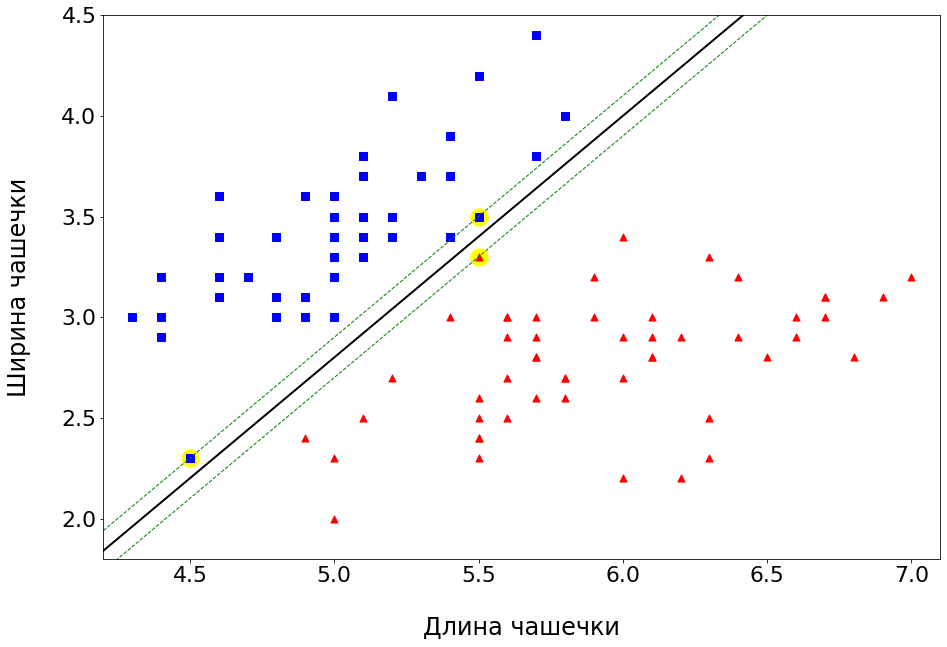

In [14]:
plot_svm(svm_outlier, X_outliers, y_outliers, *[4.2, 7.1, 1.8, 4.5])

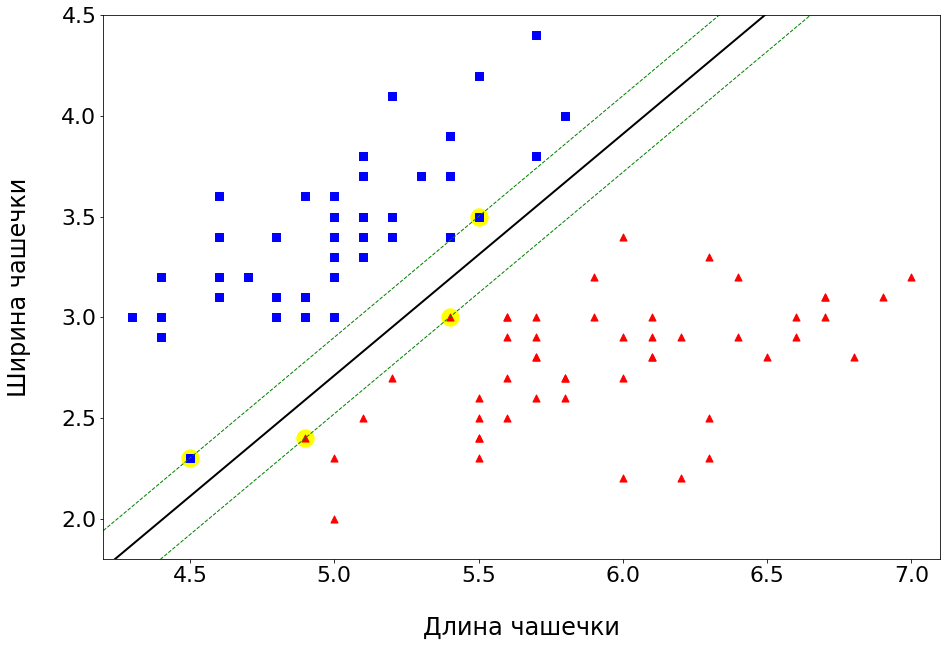

In [15]:
plot_svm(svm, X, y, *[4.2, 7.1, 1.8, 4.5])

На предыдущих картинках разница более, чем очевидна.

## Классификация с мягким зазором

Чтобы избежать подобных проблем, можно использовать более гибкую модель. Цель обучения такой модели будет состоять в нахождении хорошего баланса между тем, чтобы держать зазор на сколько возможно широким, и тем, чтобы сократить нарушение зазора. Такая классификация называется **классификацией с мягким зазором**.

Чем меньше С, тем более мягким будет зазор. И наоборот. Всегда нужно искать компромисс в том, какое С выставлять. Иметь большое количество нарушений зазора всегда плохо. Однако, в некоторых случаях такие модели будут обобщаться гораздо лучше более регуляризованных моделей.

Посмотрим как будет выглядить классификатор при `C=1`.

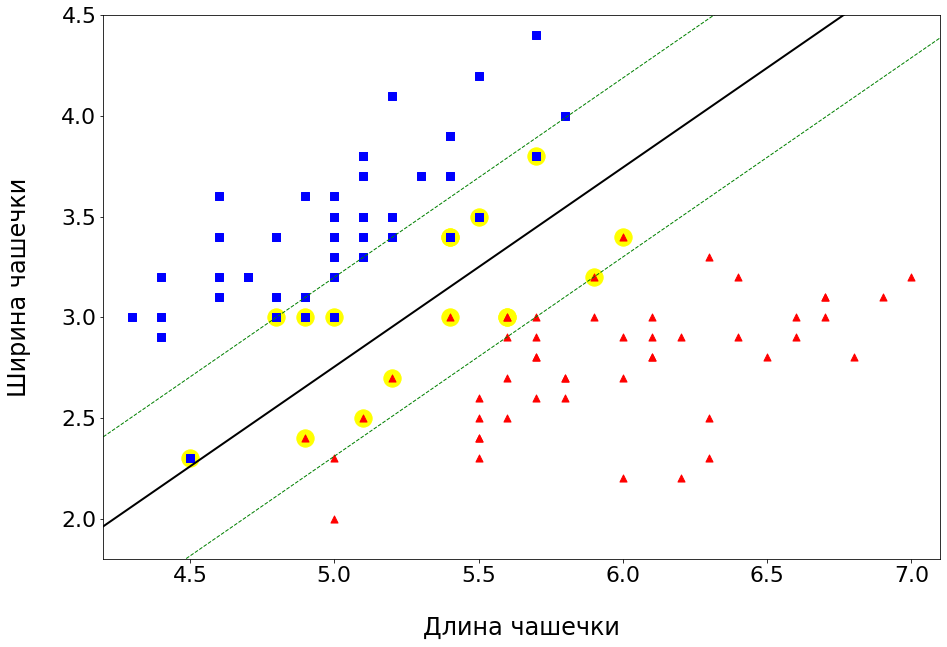

In [16]:
svm = SVC(kernel='linear', C=1)
svm.fit(X, y)
plot_svm(svm, X, y, *[4.2, 7.1, 1.8, 4.5])

А теперь при `C=100`.

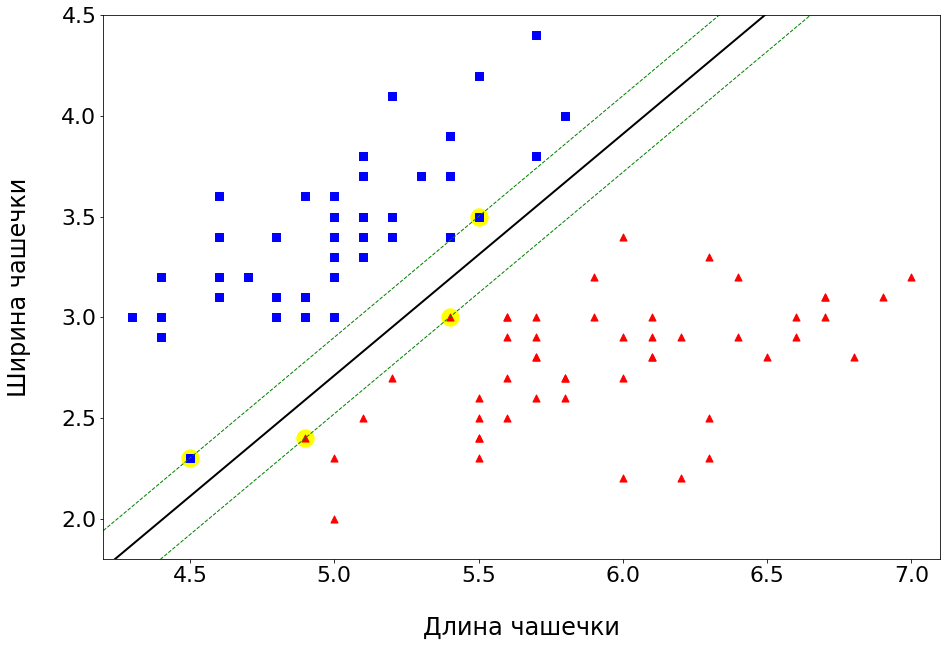

In [17]:
svm = SVC(kernel='linear', C=100)
svm.fit(X, y)
plot_svm(svm, X, y, *[4.2, 7.1, 1.8, 4.5])

# Нелинейная классификация

## Полиномиальные признаки

Многие датасеты могут быть линейно не сепарабельны и это нормально. Чтобы SVM мог обобщаться на нелинейные данные, существует несколько способов. Один подход заключается в добавлении нескольких признаков, как полиномиальные.

In [18]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

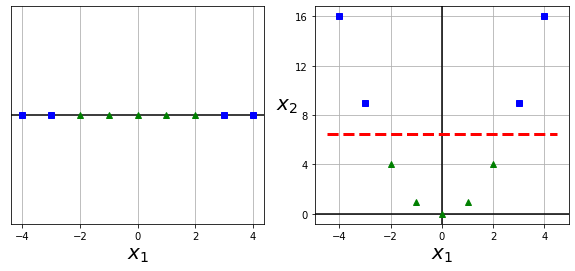

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)

plt.show()

Создадим и оценим Pipeline на датасете moons (чередующиеся полукольца).

In [20]:
from sklearn.datasets import make_moons

In [21]:
X, y = make_moons(n_samples=100, noise=0.2)

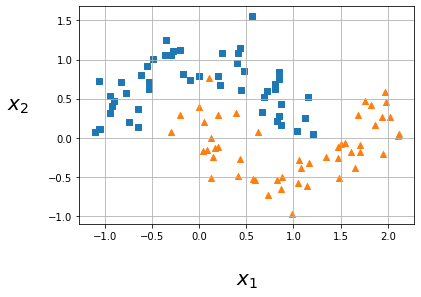

In [22]:
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker='s')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker='^')
plt.xlabel('$x_1$', fontsize=20, labelpad=30)
plt.ylabel('$x_2$', fontsize=20, rotation=0, labelpad=30)
plt.grid()
plt.show()

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

svm_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=100))
])
svm_pipeline.fit(X,y)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm', SVC(C=100, kernel='linear'))])

In [24]:
def plot_poly_svm(svm, X, y, xmin, xmax, ymin, ymax):
    # Чертим контур
    x0, x1 = np.meshgrid(np.linspace(xmin, xmax, 300), np.linspace(ymin, ymax, 300))
    Xs = np.c_[x0.ravel(), x1.ravel()]
    y_pred = svm.predict(Xs).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, alpha=0.2, cmap=plt.cm.brg)
    
    # Рисуем сам датасет
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker='s')
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker='^')
    plt.xlabel('$x_1$', fontsize=20, labelpad=30)
    plt.ylabel('$x_2$', fontsize=20, rotation=0, labelpad=30)
    plt.grid()

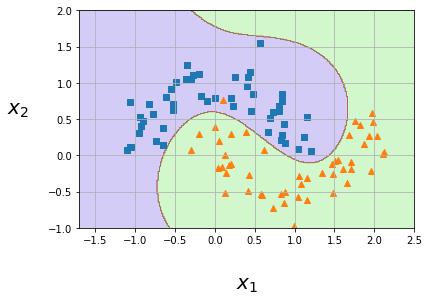

In [25]:
plot_poly_svm(svm_pipeline, X, y, *[-1.7, 2.5, -1, 2])

Выберем любые две точки, чтобы проверить корректность нашего классификатора.

In [26]:
svm_pipeline.predict([[0.5, -0.5]]), svm_pipeline.predict([[0, 1]])

(array([1]), array([0]))

Воспользуемся классом LinearSVC, выполняющая ту же работу, что и класс SVC. Просто убедимся, что в пакете `svm` уже имеются необходимые классы под конкретную задачу.

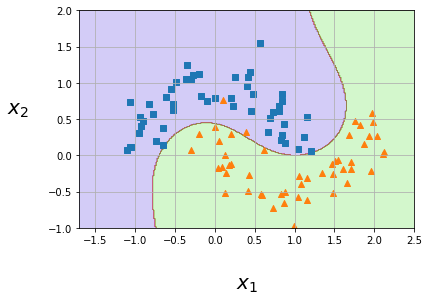

In [27]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(C=1))
])
svm_pipeline.fit(X,y)

plot_poly_svm(svm_pipeline, X, y, *[-1.7, 2.5, -1, 2])

## Полиномиальное ядро

В SVM существует практически магическая математическая техника, способная решить большое количество проблем. Такая техника называется **ядерный трюк**. К примеру, полиномиальное ядро (одно из множества ядер в SVM) позволяет получить сходный с PolynomialFeatures результат, не добавляя степенных признаков вообще. Поэтому, не возникает никакого лишнего замедления и "взрыва" степенной функции, потому что на самом деле никаких признаков вы не добавляете.

До этого мы использовали функционал `PolynomialFeatures`, чтобы задать дополнительные степени для нашего датасета. Теперь посмотрим на возможность **ядерных операций** с SVM: зададим **полиномиальное ядро** в классе `SVC` и посмотрим на результат.

Любые ядерные трюки реализуются с помощью класса **SVC(kernel=...)**, где в kernel записывается необходимое ядро.

In [28]:
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=3, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=1, coef0=1, kernel='poly'))])

В классе `SVC` при использовании `kernel='poly'` появляется возможность задать гиперпараметр `coef0`, который контролирует, насколько модель будет сильно зависеть от полиномов высокой степени, чем от полиномов низкой степени.

Посмотрим, как изменяется модель при изменении `coef0` для степени полинома 10.

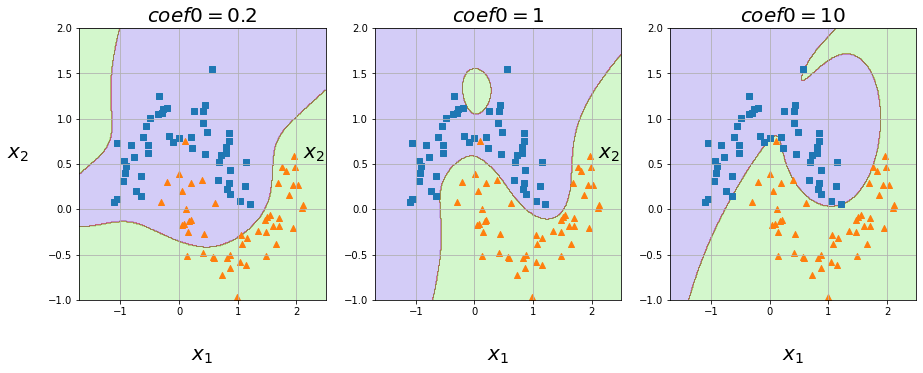

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=10, coef0=0.2, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$coef0=0.2$', fontsize=20)

plt.subplot(132)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=10, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$coef0=1$', fontsize=20)

plt.subplot(133)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=10, coef0=10, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$coef0=10$', fontsize=20)

plt.savefig('coef0_svm.png', dpi=300)
plt.show()

Теперь посмотрим на изменение степени `degree` при `coef0=1`.

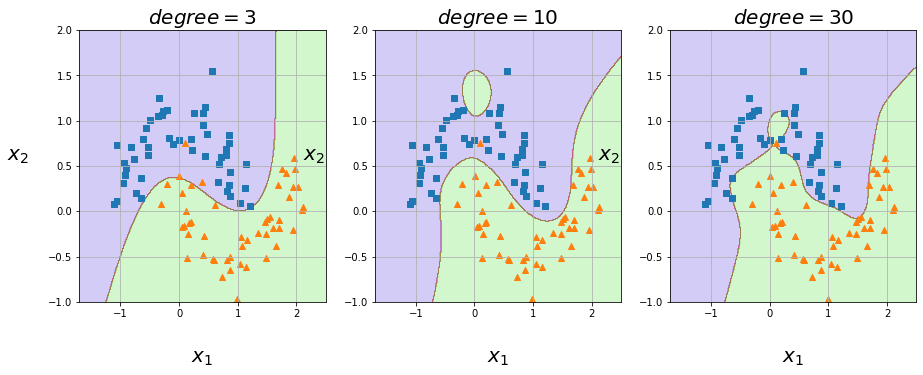

In [30]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=3, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$degree=3$', fontsize=20)

plt.subplot(132)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=10, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$degree=10$', fontsize=20)

plt.subplot(133)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=30, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$degree=30$', fontsize=20)

plt.savefig('degree_svm.png', dpi=300)
plt.show()

## Признаки сходства

Ещё одной техникой для решения проблемы нелинейности данных является добавление новых признаков, вычесленных с использованием **функции сходства**, которая измеряет насколько каждый образец схож с конкретным ориентиром.

Давайте определим функцию сходства как **функцию радиального базиса Гаусса (Gaussian Radial Basis Function - RBF)** с $\gamma=0.3$.

$$\phi_\gamma(x, l) = \exp(-\gamma\|x-l\|^2)$$

In [31]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

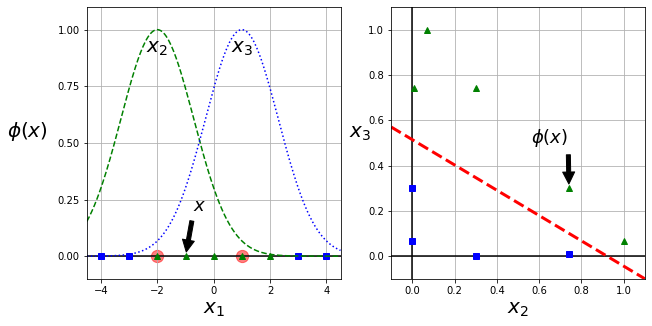

In [32]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

# Измеряем функцию RBF для значений на оси
x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 5))

# Параметры графика: сетка и отрисовка оси
plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')

# Чертим красные круги для обозначения 
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$\phi(x)$", fontsize=20, rotation=0, labelpad=30)
plt.annotate(r'$x$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops={'facecolor': 'black', 'shrink': 0.1},
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi(x)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops={'facecolor': 'black', 'shrink': 0.1},
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.show()

In [33]:
gaussian_rbf(X1D, -2, gamma)

array([3.01194212e-01, 7.40818221e-01, 1.00000000e+00, 7.40818221e-01,
       3.01194212e-01, 6.72055127e-02, 8.22974705e-03, 5.53084370e-04,
       2.03995034e-05])

In [34]:
gaussian_rbf(X1D, 1, gamma)

array([5.53084370e-04, 8.22974705e-03, 6.72055127e-02, 3.01194212e-01,
       7.40818221e-01, 1.00000000e+00, 7.40818221e-01, 3.01194212e-01,
       6.72055127e-02])

RBF изменяется от 0 (очень далеко от ориентира) до 1 (сам ориентир) - она измеряет расстояние до ориентира.

# Вычислительная сложность

Имея на выбор столько ядер, как выбрать какое из них использовать? В качестве правила можно принять следующую последовательность действий: сначала необходимо попробовать первым линейное ядро (при это важно, что LinearSVC гораздо быстрее SVC(kernal='linear'), особенно, если признаков очень много. Если же обучающий набор не слишком большой, то можно попробовать SVC(kernal='rbf'), который хорош в большинстве случаев.

|Класс|Сложность обучения|Поддержка внешнего обучения|Масштабирование|Ядерный трюк|
|:----:|:------:|:------:|:------:|:------:|
|LinearSVC|O($m*n$)|Нет|Требуется|Нет|
|SGDClassifier|O($m*n$)|Да|Требуется|Нет|
|SVC|от O($m^2*n$) до O($m^3*n$)|Нет|Требуется|Да|

# Регрессия SVM

SVM способен выполнять не только задачу классификации, но и регрессии. Прием заключается в инвертировании цели: вместо попытки приспособиться к самой широкой из возможных полосе между двумя классами, одновременно ограничивая нарушения зазора, регрессия SVM пробует уместить как можно больше образцов на полосе наряду с ограничением нарушений зазора. Ширина полосы управляется гиперпараметром **$\epsilon$**.

In [35]:
m = 50
X = 3 * np.random.rand(m, 1)
y = (3 + 4 * X + np.random.randn(m, 1)).ravel()

In [36]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5)

In [37]:
svm1 = LinearSVR(epsilon=1.5)
svm2 = LinearSVR(epsilon=0.5)
svm1.fit(X, y)
svm2.fit(X, y)

def support_vectors(svm, X, y):
    y_pred = svm.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm.epsilon)
    return np.argwhere(off_margin)

svm1.support_ = support_vectors(svm1, X, y)
svm2.support_ = support_vectors(svm2, X, y)

eps_x1 = 1
eps_y_pred = svm1.predict([[eps_x1]])

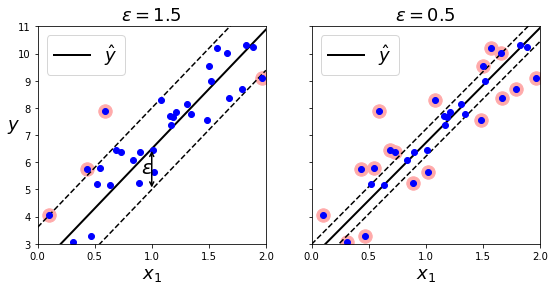

In [38]:
def plot_svm_regression(svm, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm.epsilon, "k--")
    plt.plot(x1s, y_pred - svm.epsilon, "k--")
    plt.scatter(X[svm.support_], y[svm.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm2.epsilon), fontsize=18)
plt.show()

# Математика

Линейный классификатор SVM делает прогнозы для нового образца $x$ путем простого вычисления выражения:

$$w^Tx  + b = w_1x_1 + ...+w_nx_n + b$$

И если результат положительный, то предсказанный результат $\hat{y}$ - положительный класс (1), в противном случае - отрицательный (0). Более формально:

$$\hat{y} = 
\begin{cases}
0\ \ \ if\ w^Tx+b \lt 0, \\
1\ \ \ if\ w^Tx+b \ge 0
\end{cases}$$

In [39]:
iris = load_iris()
X = iris['data'][:, (0, 1)]
y = iris['target']

X = X[(iris['target'] == 0) | (iris['target'] == 1)]
y = y[(iris['target'] == 0) | (iris['target'] == 1)]

In [41]:
svm = SVC(kernel='linear', C=float(np.inf))
svm.fit(X, y)

SVC(C=inf, kernel='linear')

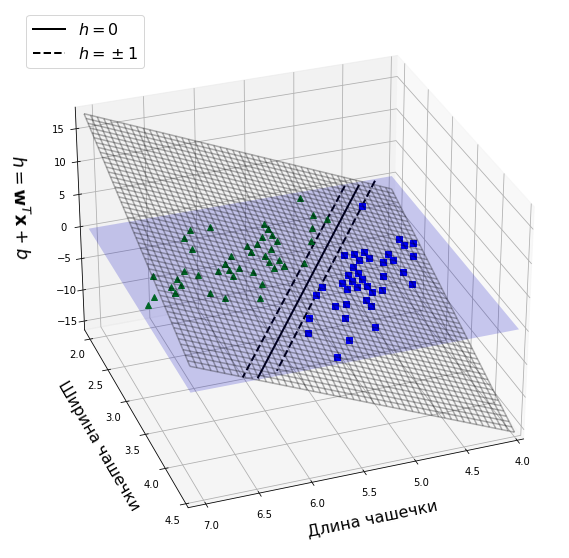

In [110]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 7.1], x2_lim=[1.9, 4.5]):
    # Задание координатной сетки
    x1s = np.linspace(x1_lim[0], x1_lim[1], 50)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 50)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    
    # Инициализация функции принятия решений (это плоскость)
    decision_function = (xs.dot(w) + b).reshape(x1.shape)
    
    # Вычисление координат линий зазора и границы решения
    boundary = -x1s*(w[0]/w[1])-b/w[1]
    margin_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    indexes_margin1 = (margin_1 <= x2_lim[1]) & (margin_1 >= x2_lim[0])
    indexes_margin2 = (margin_2 <= x2_lim[1]) & (margin_2 >= x2_lim[0])
    indexes_boundary = (boundary <= x2_lim[1]) & (boundary >= x2_lim[0])
    
    # Отрисовка линий и плоскостей
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s[indexes_boundary], boundary[indexes_boundary], 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s[indexes_margin1], margin_1[indexes_margin1], 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s[indexes_margin2], margin_2[indexes_margin2], 0, "k--", linewidth=2)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], 0, "g^")
    ax.plot_wireframe(x1, x2, decision_function, alpha=0.3, color="k")
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], 0, "bs")
    
    # Настройка осей и легенды
    ax.axis(x1_lim + x2_lim)
    ax.set_xlabel(r"Длина чашечки", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Ширина чашечки", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=20)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax, w=svm.coef_[0], b=svm.intercept_[0])

# Поворот графика
ax.view_init(30, 70)
plt.show()

На рисунке показана функция принятия решения модели: это двумерная плоскость (т.к. данные имеют только два признака).

Прерывистые линии представляют собой функции принятия решения, равные 1 или -1: они параллельны и они формируют зазор.

Обучение SVM классификатора заключается в нахождении таких $w$ и $b$, чтобы сделать этот зазор как можно шире, избегая нарушения зазора (классификация с жестким зазором) или их ограничивая (классификация с мягким зазором).

Наклон функции принятия решений эквивалентен норме вектора весов: \|w\|. Если  поделить этот наклон на два, то зазор увеличится в два раза.

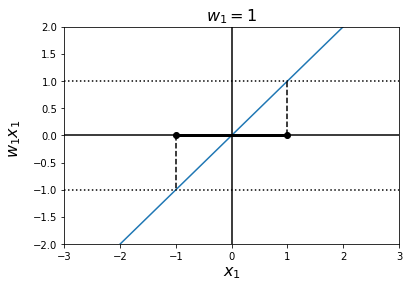

In [118]:
x = np.linspace(-3, 3, 200)
w = 1; b = 0
y = w * x + b
m = 1 / w

plt.plot(x, y)
plt.plot([-3, 3], [1, 1], "k:")
plt.plot([-3, 3], [-1, -1], "k:")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot([m, m], [0, 1], "k--")
plt.plot([-m, -m], [0, -1], "k--")
plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
plt.axis([-3, 3] + [-2, 2])
plt.xlabel(r"$x_1$", fontsize=16)
plt.ylabel(r"$w_1 x_1$  ", labelpad=10, fontsize=16)
plt.title(r"$w_1 = {}$".format(w), fontsize=16)
plt.show()

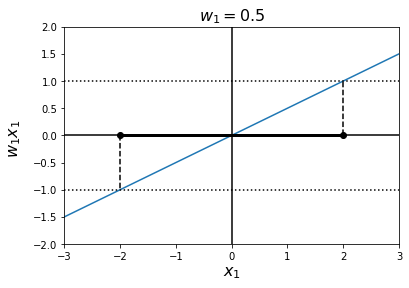

In [119]:
x = np.linspace(-3, 3, 200)
w = 0.5; b = 0
y = w * x + b
m = 1 / w

plt.plot(x, y)
plt.plot([-3, 3], [1, 1], "k:")
plt.plot([-3, 3], [-1, -1], "k:")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot([m, m], [0, 1], "k--")
plt.plot([-m, -m], [0, -1], "k--")
plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
plt.axis([-3, 3] + [-2, 2])
plt.xlabel(r"$x_1$", fontsize=16)
plt.ylabel(r"$w_1 x_1$  ", labelpad=10, fontsize=16)
plt.title(r"$w_1 = {}$".format(w), fontsize=16)
plt.show()

Поэтому, цель состоит в уменьшении нормы вектор весов для того, чтобы получить наиболее широкую полосу зазора.

Если мы также хотим избежать нарушения зазора (в случае классификации с жестким зазором), тогда нам необходимо сделать так, чтобы функция решения была больше 1 для положительных образцов и меньше -1 для отрицательных. Тогда, обозначив за $t^{(i)}$ константу, равную 1, если класс i-го образца положительный, и равную -1, если отрицательный, необходимо найти решение проблемы:

$$минимизировать\ (по\ w,b):\ \ \ \ \frac12w^Tw \\
при\ условии:\ \ \ t^{(i)}(w^Tx^{(i)}+b)\ge1$$

Чтобы достичь цели в случае классификации с мягким зазором, необходимо ввести **переменную ослабления** $\zeta \ge 0$ для каждого образца: она показывает, насколько каждому образцу дозволяется нарушить границу зазора.

Итак, мы встречаем конфликт двух целей: с одной стороны необходимо минимизировать переменную ослабления для уменьшения нарушений зазора, а с другой стороны держать $\frac12w^Tw$ настолько малыми, насколько возможно для увеличения зазора.

Вот тут и нужен гиперпараметр C: он позволяет определить компромисс между двумя целями. А потому теперь необходимо решить следующую оптимизационную проблему:

$$минимизировать\ (по\ w,b,\zeta):\ \ \ \ \frac12w^Tw+C\sum_{i=1}^m\zeta^{(i)} \\
при\ условии:\ \ \ t^{(i)}(w^Tx^{(i)}+b)\ge1-\zeta^{(i)}$$

## Ядерный трюк

Вкратце рассмотрим в чём же "магия" ядерного трюка.

Предположим, что мы хотим применить полиномиальную трансформацию данных второй степени (прямо как с классом PolynomialFeatures), а затем обучить линейный SVM на трансформированном наборе. Тогда функция $\phi$ отражает эту трансформацию: 

$$\phi(x) = \phi\bigg(\bigg(
\begin{matrix}
a \\
b
\end{matrix}\bigg)\bigg) = \Bigg(\begin{matrix}
x_1^2 \\
\sqrt{2}x_1x_2 \\
x_2^2
\end{matrix}\Bigg)$$

Теперь посмотрим что произойдёт, если мы возьмем два вектора и произведем такую трансформацию.

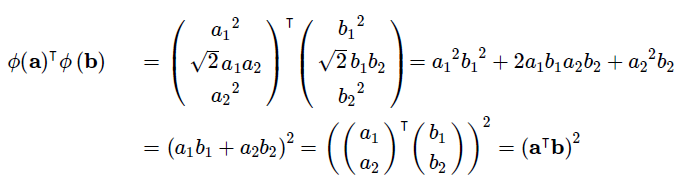

In [121]:
from IPython.display import Image
Image(data="kernel_formula.png")

Получается, что перемножение трансформированных векторов равно квадрату скалярного произведения оригинальных векторов.

Отсюда следует, что нам совсем не нужно трансформировать весь набор данных, нужно просто заменить это все квадратом их скалярного произведения. 

В машинном обучении **ядром** называется функция, способная перемножить скалярно $\phi(a)^T\phi(b)$, основываясь на оригинальных векторах без вычисления этой трансформации $\phi$.

Далее приведены основные ядра:

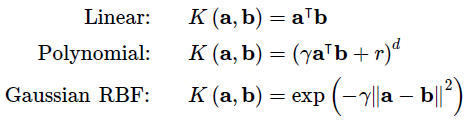

In [123]:
from IPython.display import Image
Image(data="kernels.png")

# Онлайн обучение

Существует легальный способ осуществлять онлайн обучение, используя классификатор SVM - это использование градиентного спуска для минимизации функции потерь:

$$J(w, b) = \frac12w^Tw+C\sum_{i=1}^m\max(0,1-t^{(i)}(w^Tx^{(i)}+b))$$

Первое слагаемое заставляет модель иметь маленькие веса, тем самым обеспечивая наибольший зазор. Вторая сумма вычисляет сумму всех нарушений зазора.

Функция $\max(0, 1-t)$ называется **hinge функцией потерь (hinge loss)**.

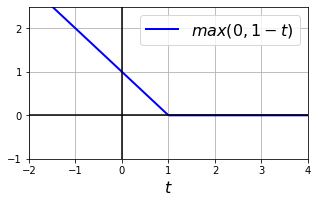

In [127]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
plt.show()